## Notebook 01 - Interpolación de series temporales

Este notebook contiene el proceso de interpolación de variables ambientales a partir de datos con fechas irregulares. Se aplican técnicas como `CubicSpline` y visualizaciones para validar la consistencia temporal de los datos interpolados.

# Interpolacion Dataset

In [2]:
import pandas as pd

df = pd.read_csv("../dataset/eda_interpolado.csv", decimal='.')

#contar duplicados en columna time
print(df[df.duplicated('time')].shape[0])

0


In [3]:
df.head()

,time,T.obs,Hr.obs,pr.obs,Rad.obs,u.obs,u_gr.obs,Td.obs,EPenman.obs,pp_obs,...,Cianorg,T_sup,CondsupC,MicrtEli,EscColi,PROFSITI,SatSupC,fitotot,pHsupC,Secc_sup
0,2020-02-14,26.145833,84.125000,1004.545833,117.666667,3.451042,207.500000,23.116667,0.056250,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-15,26.241667,82.708333,1004.579167,287.812500,2.844792,183.614583,22.945833,0.083750,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-16,26.737500,87.666667,1003.220833,202.822917,3.078125,169.270833,24.454167,0.062083,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-17,26.000000,85.875000,1000.762500,149.968750,5.366667,167.343750,23.400000,0.064583,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-18,22.666667,76.625000,1004.875000,264.114583,2.745833,161.000000,17.758333,0.085000,9.0,...,142.0,27.3,68.8,2.13,297.0,1.0,90.1,142.0,8.22,0.35


In [4]:
df.columns

Index(['time', 'T.obs', 'Hr.obs', 'pr.obs', 'Rad.obs', 'u.obs', 'u_gr.obs',
       'Td.obs', 'EPenman.obs', 'pp_obs', 'prono_PP_dia_0', 'prono_PP_dia_1',
       'prono_PP_dia_2', 'prono_PP_dia_3', 'prono_PP_dia_4', 'prono_PP_dia_5',
       'prono_PP_dia_6', 'prono_Tm_dia_0', 'prono_Tm_dia_1', 'prono_Tm_dia_2',
       'prono_Tm_dia_3', 'prono_Tm_dia_4', 'prono_Tm_dia_5', 'prono_Tm_dia_6',
       'prono_Tm_dia_7', 'Aporte_m3s', 'Nivel_emb', 'NO3_lab', 'SS_105',
       'NO2_lab', 'ODsupC', 'Doli_spp', 'TempAmb', 'TurSupC', 'PO4_lab',
       'Turb', 'ColFec', 'SS_550', 'NT', 'NH_lab', 'Enteroc', 'ColTot',
       'Ptot_lab', 'Cianobac', 'Clorof_A', 'MCys_spp', 'VientoI', 'Cianorg',
       'T_sup', 'CondsupC', 'MicrtEli', 'EscColi', 'PROFSITI', 'SatSupC',
       'fitotot', 'pHsupC', 'Secc_sup'],
      dtype='object')

# Convertir a Biovolumen de Cianobacterias la columna Cianobac

In [5]:
# Aplica la conversión a toda la columna Cianobac usando el modelo de regresión
df['Cianobac'] = 0.0001 * df['Cianobac'] + 0.2006
print(df['Cianobac'].head())


0       NaN
1       NaN
2       NaN
3       NaN
4    2.8056
Name: Cianobac, dtype: float64


# Interpolacion de valores nulos



In [6]:
import numpy as np
from scipy.interpolate import CubicSpline

def realizar_los_segmentos(df, columna, bloque_size=4, extension=3):
    not_nan_indices = df[df[columna].notna()].index
    segmentos = []
    for i in range(0, len(not_nan_indices), bloque_size):
        start = max(0, not_nan_indices[i] - extension)
        end = min(len(df), not_nan_indices[min(i + bloque_size, len(not_nan_indices) - 1)] + extension + 1)
        segmentos.append((start, end))
    return segmentos

def interpolar_segmento(df, columna, start, end):
    segment = df.iloc[start:end]
    x = segment.index
    y = segment[columna]
    not_nan = y.notna()
    if not_nan.sum() < 2:
        # No se puede interpolar con menos de 2 puntos reales
        return df
    spline = CubicSpline(x[not_nan], y[not_nan], bc_type='natural')
    interpolated = spline(x)
    # Limitar a los valores reales del segmento
    min_val = y[not_nan].min()
    max_val = y[not_nan].max()
    interpolated = np.clip(interpolated, min_val, max_val)
    # Solo sobrescribir los valores NaN
    mask = y.isna()
    df.iloc[start:end, df.columns.get_loc(columna)] = np.where(mask, interpolated, y)
    return df

def unir_segmentos(df, columna, segmentos):
    for start, end in segmentos:
        df = interpolar_segmento(df, columna, start, end)
    return df

def interpolar_columna(df, columna):
    df = df.copy()
    original = df[columna].copy()
    segmentos = realizar_los_segmentos(df, columna)
    df = unir_segmentos(df, columna, segmentos)
    # Restaurar los valores reales (por si acaso)
    df.loc[original.notna(), columna] = original[original.notna()]
    # Limitar los valores interpolados: mínimo 0, máximo el valor real máximo
    min_val = 0
    max_val = original.max()
    df[columna] = df[columna].clip(lower=min_val, upper=max_val)
    return df

In [7]:
def interpolar_todas_las_columnas(df):
    df_resultado = df.copy()
    columnas_con_nan = df.columns[df.isna().any()]
    for col in columnas_con_nan:
        df_resultado = interpolar_columna(df_resultado, col)
    return df_resultado

# Uso:
df = interpolar_todas_las_columnas(df)

In [8]:
df.isna().sum()

time                0
T.obs               0
Hr.obs              0
pr.obs              0
Rad.obs             0
u.obs               0
u_gr.obs            0
Td.obs              0
EPenman.obs         0
pp_obs              0
prono_PP_dia_0      0
prono_PP_dia_1      0
prono_PP_dia_2      0
prono_PP_dia_3      0
prono_PP_dia_4      0
prono_PP_dia_5      0
prono_PP_dia_6      0
prono_Tm_dia_0      0
prono_Tm_dia_1      0
prono_Tm_dia_2      0
prono_Tm_dia_3      0
prono_Tm_dia_4      0
prono_Tm_dia_5      0
prono_Tm_dia_6      0
prono_Tm_dia_7      0
Aporte_m3s          0
Nivel_emb           0
NO3_lab             9
SS_105              9
NO2_lab             9
ODsupC              2
Doli_spp          492
TempAmb             2
TurSupC           680
PO4_lab             9
Turb              785
ColFec            492
SS_550              9
NT                  9
NH_lab              9
Enteroc             2
ColTot            562
Ptot_lab            9
Cianobac            2
Clorof_A            9
MCys_spp  

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

def visualizar_tendencia(df, columna, titulo=None, color='blue', escala_log=False, 
                         rolling_window=None, figsize=(12, 6), fecha_formato=None):
    """
    Función que genera una visualización de tendencia temporal para una columna específica.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame que contiene los datos a visualizar.
    columna : str
        Nombre de la columna a visualizar.
    titulo : str, opcional
        Título del gráfico. Si es None, se usa el nombre de la columna.
    color : str, opcional
        Color de la línea de tendencia.
    escala_log : bool, opcional
        Si es True, se aplica escala logarítmica al eje Y.
    rolling_window : int, opcional
        Si se especifica, se muestra una media móvil con la ventana indicada.
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto).
    fecha_formato : str, opcional
        Formato de fecha para el eje X. Si es None, se detecta automáticamente.
        
    Retorna:
    --------
    fig, ax : objetos de matplotlib
        La figura y el eje del gráfico generado.
    """
    # Verificar que la columna exista en el DataFrame
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el DataFrame")
    
    # Verificar que exista la columna 'time'
    if 'time' not in df.columns:
        raise ValueError("El DataFrame debe contener una columna 'time' para la visualización temporal")
    
    # Crear una copia del DataFrame para no modificar el original
    df_plot = df.copy()
    
    # Convertir la columna 'time' a datetime si no lo es ya
    if not pd.api.types.is_datetime64_any_dtype(df_plot['time']):
        try:
            # Intentar diferentes formatos de fecha
            if fecha_formato:
                df_plot['time'] = pd.to_datetime(df_plot['time'], format=fecha_formato)
            else:
                df_plot['time'] = pd.to_datetime(df_plot['time'])
        except Exception as e:
            print(f"Error al convertir la columna 'time' a formato datetime: {e}")
            print("Usando índices numéricos en su lugar.")
            df_plot['time'] = range(len(df_plot))
    
    # Ordenar el DataFrame por la columna de tiempo
    df_plot = df_plot.sort_values('time')
    
    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=figsize)
    
    # Graficar la serie temporal
    ax.plot(df_plot['time'], df_plot[columna], color=color, alpha=0.7, label=columna)
    
    # Añadir media móvil si se especifica
    if rolling_window is not None and rolling_window > 0:
        rolling_mean = df_plot[columna].rolling(window=rolling_window).mean()
        ax.plot(df_plot['time'], rolling_mean, color='red', 
                linewidth=2, label=f'Media móvil ({rolling_window} períodos)')
    
    # Configurar escala logarítmica si se solicita
    if escala_log and (df_plot[columna] > 0).all():
        ax.set_yscale('log')
    
    # Añadir título y etiquetas
    if titulo:
        ax.set_title(titulo, fontsize=14)
    else:
        ax.set_title(f'Tendencia temporal de {columna}', fontsize=14)
    
    ax.set_xlabel('Tiempo', fontsize=12)
    ax.set_ylabel(columna, fontsize=12)
    
    # Mejorar la apariencia del gráfico
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Añadir leyenda si hay media móvil
    if rolling_window is not None:
        ax.legend()
    
    return fig, ax

# Función adicional para visualizar múltiples columnas
def visualizar_multiples_tendencias(df, columnas, titulo=None, figsize=(15, 10), 
                                   escala_log=False, rolling_window=None, fecha_formato=None):
    """
    Visualiza tendencias temporales para múltiples columnas en subplots.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame que contiene los datos a visualizar.
    columnas : list
        Lista de nombres de columnas a visualizar.
    titulo : str, opcional
        Título general del gráfico.
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto).
    escala_log : bool o list, opcional
        Si es True, se aplica escala logarítmica a todos los ejes Y.
        Si es una lista de booleanos, debe tener la misma longitud que columnas.
    rolling_window : int o list, opcional
        Ventana para la media móvil. Puede ser un valor único o una lista.
    fecha_formato : str, opcional
        Formato de fecha para el eje X.
        
    Retorna:
    --------
    fig : objeto de matplotlib
        La figura del gráfico generado.
    """
    # Verificar que las columnas existan en el DataFrame
    for col in columnas:
        if col not in df.columns:
            raise ValueError(f"La columna '{col}' no existe en el DataFrame")
    
    # Determinar el número de filas y columnas para los subplots
    n_cols = min(2, len(columnas))
    n_rows = (len(columnas) + n_cols - 1) // n_cols
    
    # Crear la figura y los ejes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Aplanar el array de ejes si es necesario
    if len(columnas) > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Convertir escala_log y rolling_window a listas si no lo son
    if isinstance(escala_log, bool):
        escala_log = [escala_log] * len(columnas)
    
    if rolling_window is not None and not isinstance(rolling_window, list):
        rolling_window = [rolling_window] * len(columnas)
    
    # Crear una copia del DataFrame para no modificar el original
    df_plot = df.copy()
    
    # Convertir la columna 'time' a datetime si no lo es ya
    if not pd.api.types.is_datetime64_any_dtype(df_plot['time']):
        try:
            if fecha_formato:
                df_plot['time'] = pd.to_datetime(df_plot['time'], format=fecha_formato)
            else:
                df_plot['time'] = pd.to_datetime(df_plot['time'])
        except Exception as e:
            print(f"Error al convertir la columna 'time' a formato datetime: {e}")
            print("Usando índices numéricos en su lugar.")
            df_plot['time'] = range(len(df_plot))
    
    # Ordenar el DataFrame por la columna de tiempo
    df_plot = df_plot.sort_values('time')
    
    # Graficar cada columna en su propio subplot
    for i, col in enumerate(columnas):
        if i < len(axes):
            ax = axes[i]
            
            # Graficar la serie temporal
            ax.plot(df_plot['time'], df_plot[col], alpha=0.7, label=col)
            
            # Añadir media móvil si se especifica
            if rolling_window is not None and rolling_window[i] > 0:
                rolling_mean = df_plot[col].rolling(window=rolling_window[i]).mean()
                ax.plot(df_plot['time'], rolling_mean, color='red', 
                        linewidth=2, label=f'Media móvil ({rolling_window[i]} períodos)')
            
            # Configurar escala logarítmica si se solicita
            if escala_log[i] and (df_plot[col] > 0).all():
                ax.set_yscale('log')
            
            # Añadir título y etiquetas
            ax.set_title(f'Tendencia de {col}', fontsize=12)
            ax.set_xlabel('Tiempo', fontsize=10)
            ax.set_ylabel(col, fontsize=10)
            
            # Mejorar la apariencia del gráfico
            ax.grid(True, alpha=0.3)
            plt.setp(ax.get_xticklabels(), rotation=45)
            
            # Añadir leyenda si hay media móvil
            if rolling_window is not None and rolling_window[i] > 0:
                ax.legend()
    
    # Ocultar ejes vacíos si hay más ejes que columnas
    for i in range(len(columnas), len(axes)):
        axes[i].set_visible(False)
    
    # Añadir título general si se especifica
    if titulo:
        fig.suptitle(titulo, fontsize=16)
    
    plt.tight_layout()
    if titulo:
        plt.subplots_adjust(top=0.9)  # Ajustar para dejar espacio para el título
    
    return fig


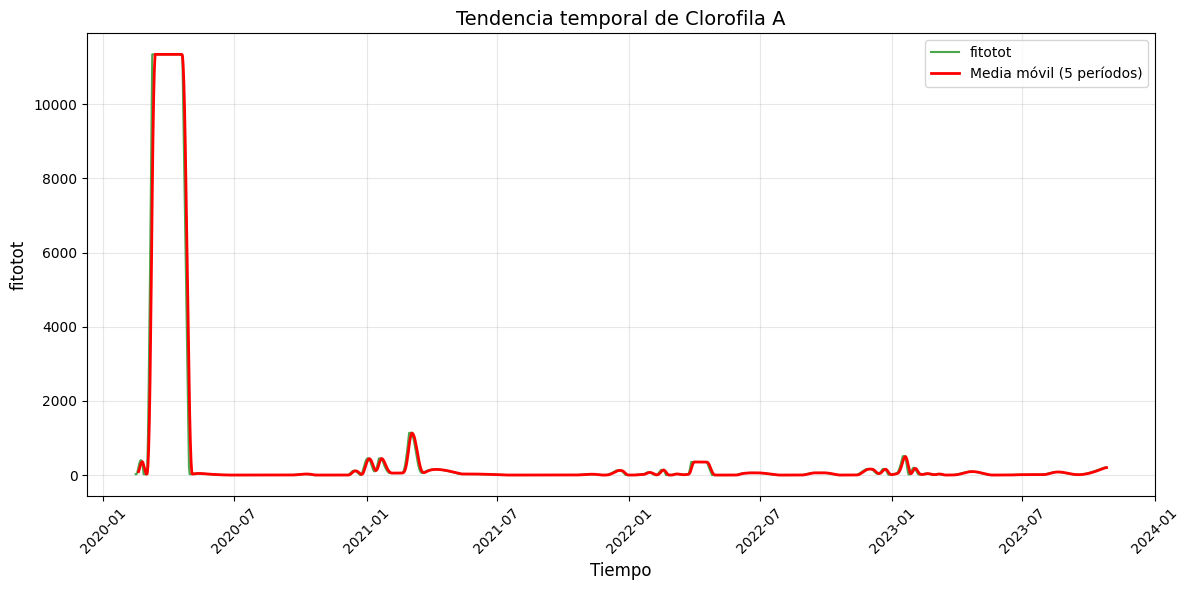

In [12]:
# Ejemplo 1: Visualizar tendencia de una sola columna
fig1, ax1 = visualizar_tendencia(df, 'fitotot', 
                                titulo='Tendencia temporal de Clorofila A',
                                color='green', 
                                rolling_window=5)

plt.show()

Se eliminan los atributos que dejaron de medirce en el 2023 dado que generan muchos nan y el modelo capta patrones que no existen en la actualidad (si solo canvertimos a 0 los nan).

fitotot, Cianoorg, MCyS_spp, ColTot, ColFec Doli_spp.

Para Turb (medicicon de laboratorio de la turbidez) se deja de medir en el 2023 y para TurSupC (medicion de campo de la turbidez) se empieza a medir en el 2021. Decicion: se toma TurSupC como el atributo principal de turbidez y se completa con turb caundo no se tenga TurSupC.

In [13]:
# Eliminar atributos que dejaron de medirse en 2023
atributos_a_eliminar = ['fitotot', 'Cianorg', 'MCys_spp', 'ColTot', 'ColFec', 'Doli_spp']

# Verificar cuáles de estos atributos existen en el DataFrame
atributos_existentes = [col for col in atributos_a_eliminar if col in df.columns]

# Mostrar información antes de eliminar
print(f"Dimensiones del DataFrame antes: {df.shape}")

# Eliminar las columnas
df = df.drop(columns=atributos_existentes)

# Mostrar información después de eliminar
print(f"Dimensiones del DataFrame después: {df.shape}")
print(f"Columnas eliminadas: {atributos_existentes}")

# Verificar si alguna columna no se encontró
no_encontradas = [col for col in atributos_a_eliminar if col not in atributos_existentes]
if no_encontradas:
    print(f"Advertencia: Las siguientes columnas no se encontraron en el DataFrame: {no_encontradas}")

Dimensiones del DataFrame antes: (1842, 57)
Dimensiones del DataFrame después: (1842, 51)
Columnas eliminadas: ['fitotot', 'Cianorg', 'MCys_spp', 'ColTot', 'ColFec', 'Doli_spp']


In [14]:
# Completar TurSupC con Turb cuando TurSupC no esté disponible (NaN)
if 'TurSupC' in df.columns and 'Turb' in df.columns:
    df['TurSupC'] = df['TurSupC'].combine_first(df['Turb'])
    # Si ya no necesitas la columna Turb, puedes eliminarla
    df = df.drop(columns=['Turb'])
    print("TurSupC completado con los valores de Turb donde era NaN.")
else:
    print("Alguna de las columnas 'TurSupC' o 'Turb' no existe en el DataFrame.")

TurSupC completado con los valores de Turb donde era NaN.


# Los valores NaN en el dataset luego de la interpolacion se imputan con 0

In [15]:
df = df.fillna(0)

In [16]:
df.isna().sum()

time              0
T.obs             0
Hr.obs            0
pr.obs            0
Rad.obs           0
u.obs             0
u_gr.obs          0
Td.obs            0
EPenman.obs       0
pp_obs            0
prono_PP_dia_0    0
prono_PP_dia_1    0
prono_PP_dia_2    0
prono_PP_dia_3    0
prono_PP_dia_4    0
prono_PP_dia_5    0
prono_PP_dia_6    0
prono_Tm_dia_0    0
prono_Tm_dia_1    0
prono_Tm_dia_2    0
prono_Tm_dia_3    0
prono_Tm_dia_4    0
prono_Tm_dia_5    0
prono_Tm_dia_6    0
prono_Tm_dia_7    0
Aporte_m3s        0
Nivel_emb         0
NO3_lab           0
SS_105            0
NO2_lab           0
ODsupC            0
TempAmb           0
TurSupC           0
PO4_lab           0
SS_550            0
NT                0
NH_lab            0
Enteroc           0
Ptot_lab          0
Cianobac          0
Clorof_A          0
VientoI           0
T_sup             0
CondsupC          0
MicrtEli          0
EscColi           0
PROFSITI          0
SatSupC           0
pHsupC            0
Secc_sup          0


In [17]:
atributos = ['Enteroc', 'EscColi', 'Cianobac', 'Clorof_A']

for atributo in atributos:
    min_val = df[atributo].min()
    max_val = df[atributo].max()
    print(f"{atributo}: Min = {min_val}, Max = {max_val}")

Enteroc: Min = 0.0, Max = 3390.0
EscColi: Min = 0.0, Max = 873.0
Cianobac: Min = 0.0, Max = 240.76010000000002
Clorof_A: Min = 0.0, Max = 1257.0


In [18]:
atributos = ['time']

for atributo in atributos:
    min_val = df[atributo].min()
    max_val = df[atributo].max()
    print(f"{atributo}: Min = {min_val}, Max = {max_val}")

time: Min = 2020-02-14, Max = 2025-02-28


# Correccion de valores negativos

In [19]:
atributos = [
    'NO3_lab', 'SS_105', 'NO2_lab', 'ODsupC', 'TempAmb', 'TurSupC', 
    'PO4_lab', 'SS_550', 'NT', 'NH_lab', 'Enteroc', 'Ptot_lab', 'Cianobac', 'Clorof_A', 
    'VientoI', 'T_sup', 'CondsupC', 'MicrtEli', 'EscColi', 'PROFSITI', 'SatSupC', 
    'pHsupC', 'Secc_sup'
]

for atributo in atributos:
    df[atributo] = df[atributo].apply(lambda x: max(x, 0))

Estadísticas descriptivas de Cianobac:
count    1842.000000
mean        7.715375
std        38.081021
min         0.000000
25%         0.201379
50%         0.237477
75%         0.386521
max       240.760100
Name: Cianobac, dtype: float64

Valores nulos en Cianobac: 0
Valores únicos en Cianobac: 1203


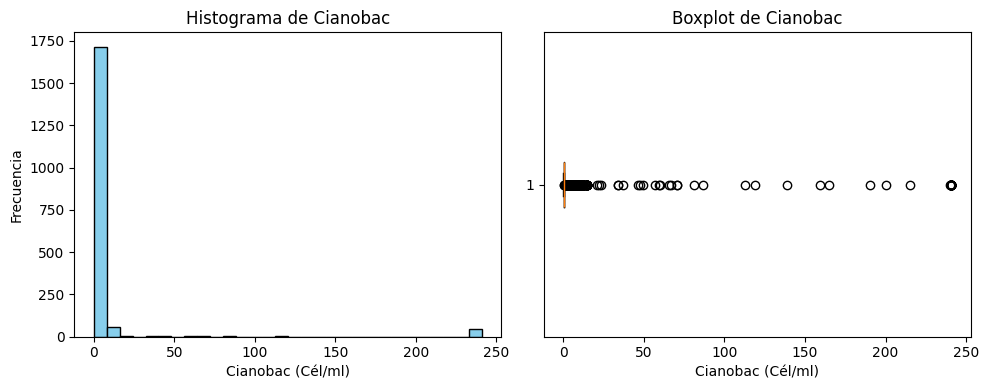

In [20]:
import matplotlib.pyplot as plt

# Estadísticas descriptivas
print("Estadísticas descriptivas de Cianobac:")
print(df['Cianobac'].describe())

# Conteo de valores nulos y únicos
print("\nValores nulos en Cianobac:", df['Cianobac'].isnull().sum())
print("Valores únicos en Cianobac:", df['Cianobac'].nunique())

# Histograma
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Cianobac'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Cianobac')
plt.xlabel('Cianobac (Cél/ml)')
plt.ylabel('Frecuencia')

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(df['Cianobac'].dropna(), vert=False)
plt.title('Boxplot de Cianobac')
plt.xlabel('Cianobac (Cél/ml)')

plt.tight_layout()
plt.show()

In [21]:
# Ordenar por Cianobac descendente y mostrar los días con los valores más altos, en decimal
top_cianobac = df.sort_values(by='Cianobac', ascending=False)[['time', 'Cianobac']].head(10)
top_cianobac['Cianobac'] = top_cianobac['Cianobac'].apply(lambda x: f"{x:,.2f}")
print(top_cianobac)

          time Cianobac
39  2020-03-24   240.76
38  2020-03-23   240.76
37  2020-03-22   240.76
36  2020-03-21   240.76
35  2020-03-20   240.76
42  2020-03-27   240.76
34  2020-03-19   240.76
41  2020-03-26   240.76
40  2020-03-25   240.76
52  2020-04-06   240.76


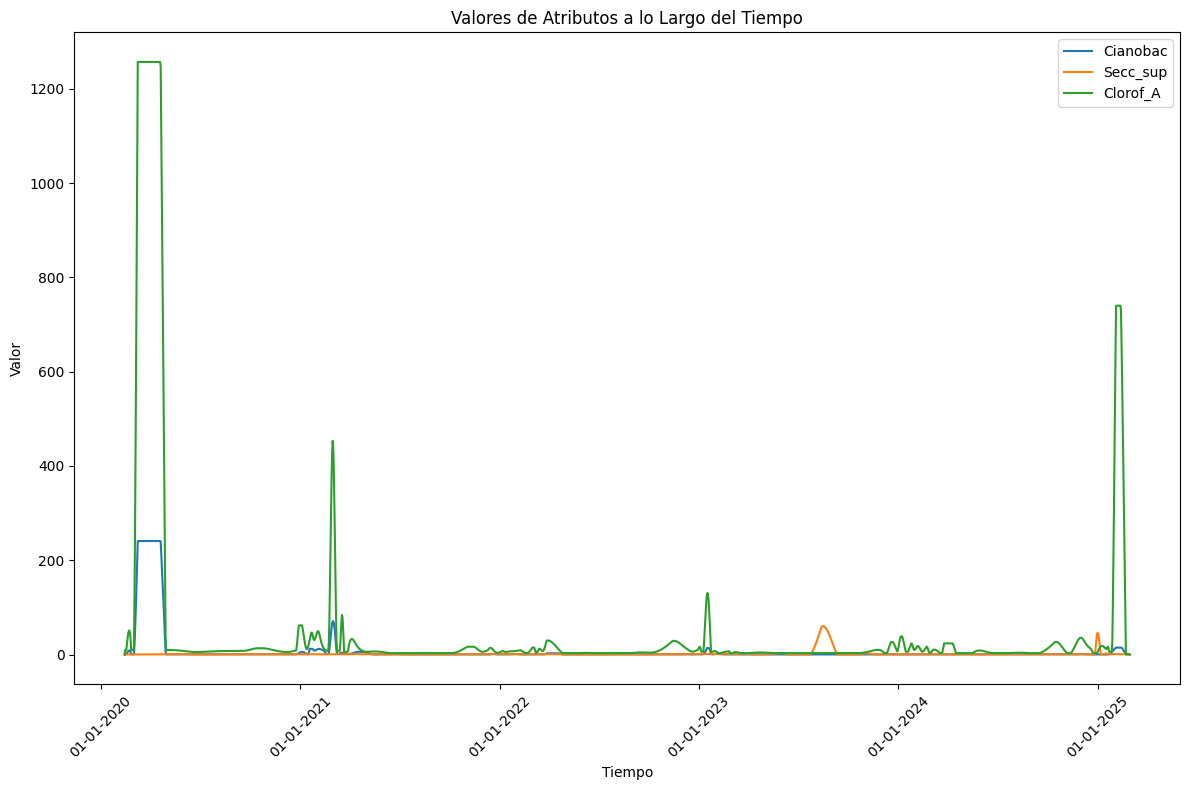

In [22]:
import matplotlib.pyplot as plt

# Asegúrate de que 'time' sea datetime
df['time'] = pd.to_datetime(df['time'])

atributos = ['Cianobac', 'Secc_sup', 'Clorof_A']

plt.figure(figsize=(12, 8))

for atributo in atributos:
    plt.plot(df['time'], df[atributo], label=atributo)

plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Valores de Atributos a lo Largo del Tiempo')
plt.legend()

# Personalizar el eje x para mostrar solo el 01-01-yyyy de cada año
import matplotlib.dates as mdates

# Ubicación de los ticks: uno por año
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('01-01-%Y')
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Asignar TARGET!!

In [23]:
df.columns

Index(['time', 'T.obs', 'Hr.obs', 'pr.obs', 'Rad.obs', 'u.obs', 'u_gr.obs',
       'Td.obs', 'EPenman.obs', 'pp_obs', 'prono_PP_dia_0', 'prono_PP_dia_1',
       'prono_PP_dia_2', 'prono_PP_dia_3', 'prono_PP_dia_4', 'prono_PP_dia_5',
       'prono_PP_dia_6', 'prono_Tm_dia_0', 'prono_Tm_dia_1', 'prono_Tm_dia_2',
       'prono_Tm_dia_3', 'prono_Tm_dia_4', 'prono_Tm_dia_5', 'prono_Tm_dia_6',
       'prono_Tm_dia_7', 'Aporte_m3s', 'Nivel_emb', 'NO3_lab', 'SS_105',
       'NO2_lab', 'ODsupC', 'TempAmb', 'TurSupC', 'PO4_lab', 'SS_550', 'NT',
       'NH_lab', 'Enteroc', 'Ptot_lab', 'Cianobac', 'Clorof_A', 'VientoI',
       'T_sup', 'CondsupC', 'MicrtEli', 'EscColi', 'PROFSITI', 'SatSupC',
       'pHsupC', 'Secc_sup'],
      dtype='object')

In [24]:
def calcular_alerta(row):
    # Alerta 3: todos los criterios deben cumplirse
    if (row['Cianobac'] > 8) and (row['Clorof_A'] > 24) and (row['Secc_sup'] < 1):
        return 3

    # Alerta 0: uno u otro criterio
    elif (row['Cianobac'] < 1) or (row['Clorof_A'] < 3) and (row['Secc_sup'] > 2):
        return 0    

    # Alerta 1: uno u otro criterio, y secc_sup < 2
    elif ((row['Cianobac'] < 4) and (row['Clorof_A'] < 12)) or (row['Secc_sup'] < 0.7):
        return 1

    # Alerta 2: uno u otro criterio, y secc_sup < 1
    elif ((row['Cianobac'] < 8) or (row['Clorof_A'] < 24)) or (row['Secc_sup'] < 1):
        return 2

        # Si no cumple ninguna de las anteriores, puede devolver 0 o np.nan según tu preferencia
    return 0

## Generacion de alertas

In [25]:
df['nivel_alerta'] = df.apply(calcular_alerta, axis=1)


In [26]:
conteo_alertas = df['nivel_alerta'].value_counts().sort_index()
print(conteo_alertas)

nivel_alerta
0    1562
1     128
2      38
3     114
Name: count, dtype: int64


## Asignacion de Target

In [27]:
df = df.sort_values('time')
df['target'] = df['nivel_alerta'].shift(-7)  # si es diario

In [28]:
#si exiten nan en target sacar registros
df.dropna(subset=['target'], inplace=True)

#elimino Nivel_alerta
df.drop(columns=['nivel_alerta'], inplace=True)

# Guardo dataset FINAL

In [ ]:
df.to_csv('../dataset/final.csv', index=False)

# EDA o AED

Estadísticas descriptivas:
                      time        T.obs       Hr.obs       pr.obs  \
count                 1835  1835.000000  1835.000000  1835.000000   
mean   2022-08-19 00:00:00    20.216714    73.841844  1009.870474   
min    2020-02-14 00:00:00     5.758333    34.041667   992.995833   
25%    2021-05-17 12:00:00    15.827083    64.479167  1006.056250   
50%    2022-08-19 00:00:00    20.625000    74.375000  1009.470833   
75%    2023-11-20 12:00:00    24.575000    83.916667  1013.116667   
max    2025-02-21 00:00:00    34.304167    99.958333  1028.445833   
std                    NaN     5.564846    12.782623     5.491962   

           Rad.obs        u.obs     u_gr.obs       Td.obs  EPenman.obs  \
count  1835.000000  1835.000000  1835.000000  1835.000000  1835.000000   
mean    202.887776     2.667916   135.257193    14.861388     0.076353   
min   -1003.333333 -1039.612500  -938.052083    -1.804167     0.002083   
25%     123.145833     1.470833   102.130208    11.4020

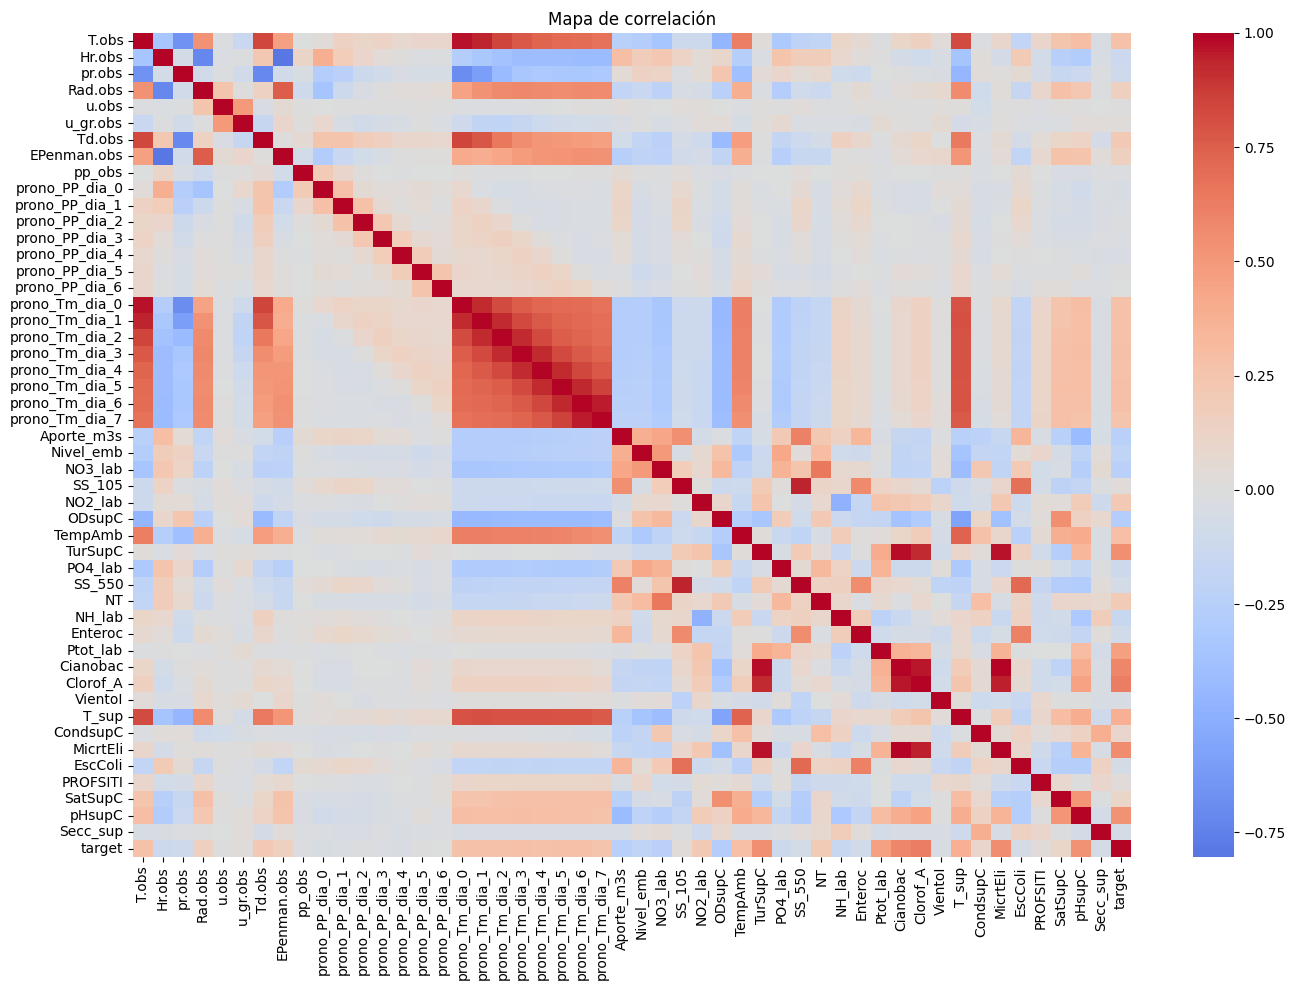

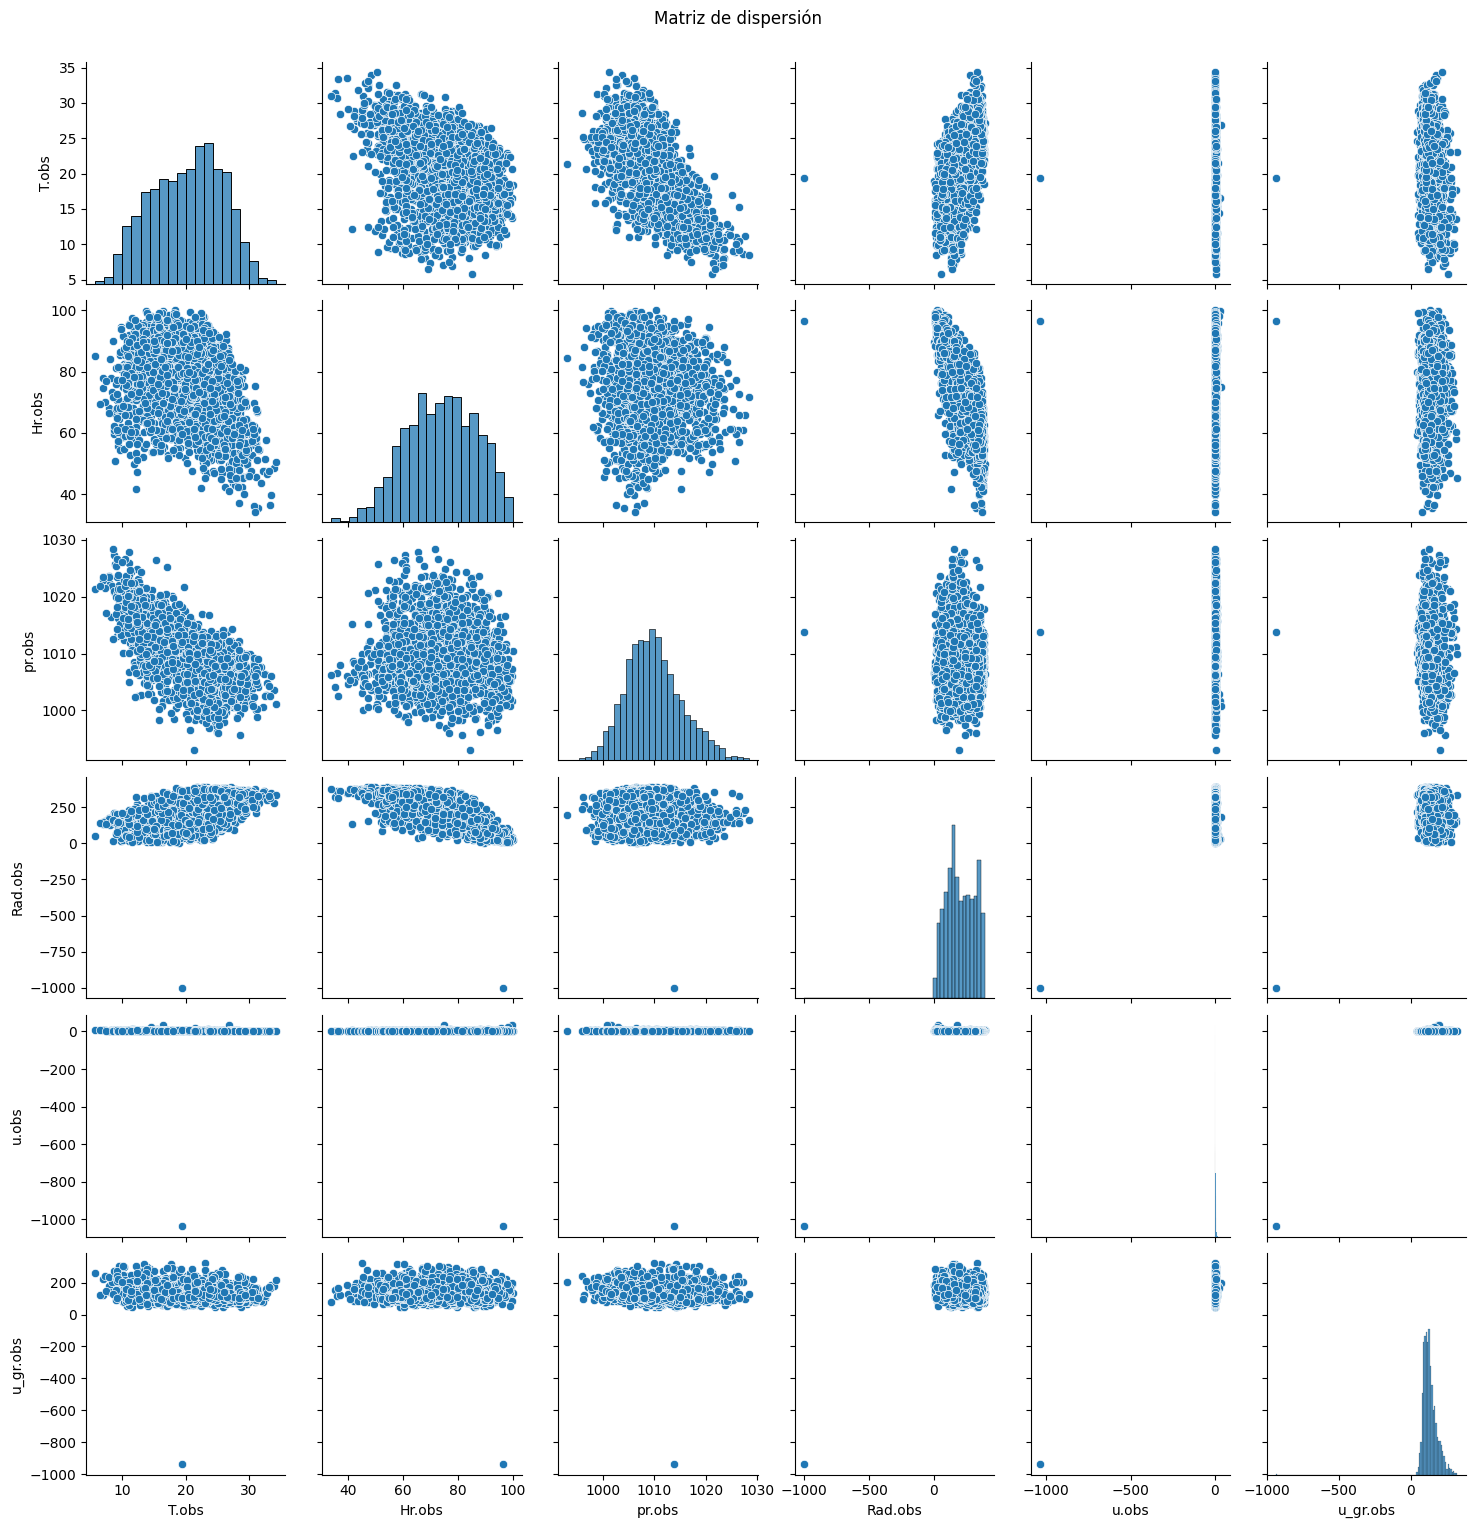

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Estadísticas descriptivas ---
print("Estadísticas descriptivas:")
print(df.describe())

# --- 2. Mapa de correlación ---
plt.figure(figsize=(14, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Mapa de correlación')
plt.tight_layout()
plt.show()

# --- 3. Matriz de dispersión (pairplot) ---
# Selecciona un subconjunto si tienes muchas variables
num_cols = df.select_dtypes(include='number').columns
if len(num_cols) > 6:
    cols_to_plot = num_cols[:6]  # Cambia este número según tu preferencia
else:
    cols_to_plot = num_cols

sns.pairplot(df[cols_to_plot].dropna())
plt.suptitle('Matriz de dispersión', y=1.02)
plt.show()


### Meteorológicas ###


,count,mean,std,min,25%,50%,75%,max
T.obs,1835.0,20.216714,5.564846,5.758333,15.827083,20.625000,24.575000,34.304167
Hr.obs,1835.0,73.841844,12.782623,34.041667,64.479167,74.375000,83.916667,99.958333
pr.obs,1835.0,1009.870474,5.491962,992.995833,1006.056250,1009.470833,1013.116667,1028.445833
Rad.obs,1835.0,202.887776,107.359943,-1003.333333,123.145833,193.041667,297.526042,391.083333
u.obs,1835.0,2.667916,24.472554,-1039.612500,1.470833,2.459375,4.344271,36.536458
Td.obs,1835.0,14.861388,5.080283,-1.804167,11.402083,15.387500,18.712500,25.750000
pp_obs,1835.0,4.392371,34.939888,-53.000000,0.000000,0.000000,0.000000,1001.000000



### Hidrológicas ###


,count,mean,std,min,25%,50%,75%,max
Aporte_m3s,1835.0,4874.604126,4884.390330,410.00,1361.428571,3385.714286,6522.857143,25360.00
Nivel_emb,1835.0,33.706865,1.071004,30.87,32.820000,33.770000,34.645000,35.42



### Biológicas ###


,count,mean,std,min,25%,50%,75%,max
Clorof_A,1835.0,52.227190,207.689469,0.0,3.099709,6.209187,12.727069,1257.0000
Enteroc,1835.0,222.503629,627.536953,0.0,10.000000,26.840106,79.001928,3390.0000
Cianobac,1835.0,7.739921,38.151526,0.0,0.201359,0.237269,0.378300,240.7601



### Químicas ###


,count,mean,std,min,25%,50%,75%,max
NO2_lab,1835.0,0.014153,0.010181,0.0,0.008000,0.008004,0.018034,0.061
NO3_lab,1835.0,0.904462,0.435496,0.0,0.531411,0.900000,1.200000,2.000
NH_lab,1835.0,0.094036,0.076073,0.0,0.025336,0.066079,0.155303,0.430
NT,1835.0,1.315614,0.524251,0.0,1.000000,1.288360,1.577587,4.000
Ptot_lab,1835.0,0.072483,0.095513,0.0,0.027424,0.039922,0.070000,0.700
PO4_lab,1835.0,0.031388,0.014725,0.0,0.020010,0.026424,0.036813,0.090
SS_105,1835.0,12.605518,7.481968,0.0,7.836374,10.442414,14.899680,42.700
SS_550,1835.0,8.600161,6.289529,0.0,4.405090,7.047855,10.800000,34.700



### Otros ###


,count,mean,std,min,25%,50%,75%,max
TempAmb,1835.0,22.842951,5.303160,0.0,19.622761,23.718905,26.177041,35.30
pHsupC,1835.0,7.715799,0.532707,0.0,7.372486,7.585035,7.970000,9.61
VientoI,1835.0,7.343235,5.194186,0.0,4.486524,5.638778,10.069858,24.00
SatSupC,1835.0,98.122709,10.615338,0.0,92.099052,96.112778,101.817386,169.30
T_sup,1835.0,21.713137,4.886662,0.0,17.014311,21.724208,26.184140,30.70
CondsupC,1835.0,68.117907,19.107958,0.0,58.467069,64.733499,70.119787,157.50


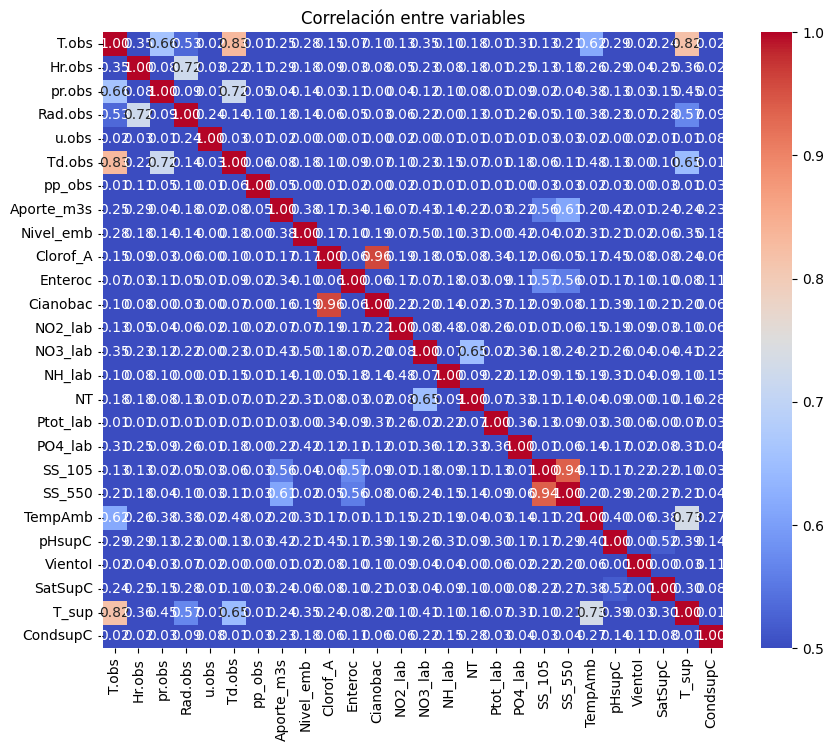

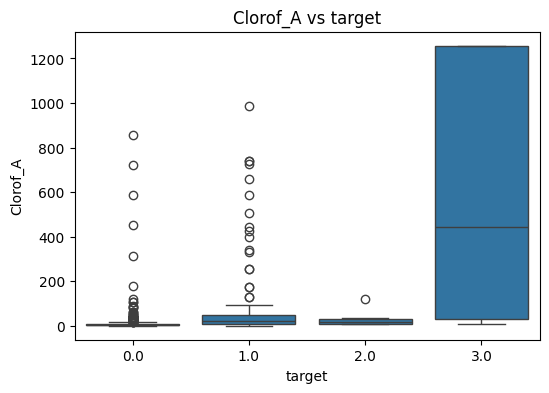

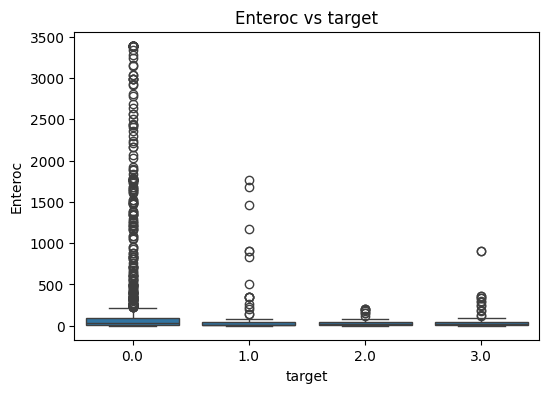

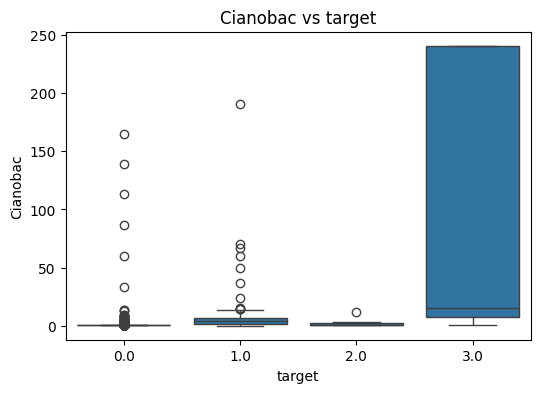

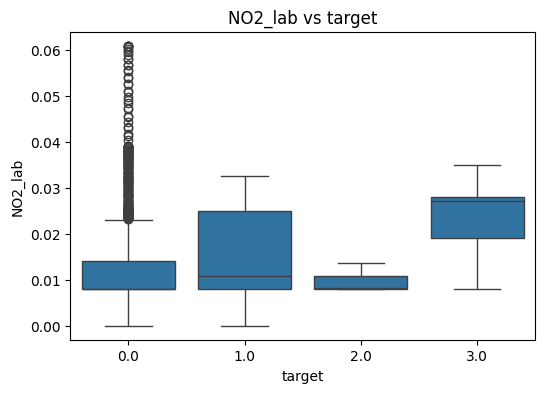

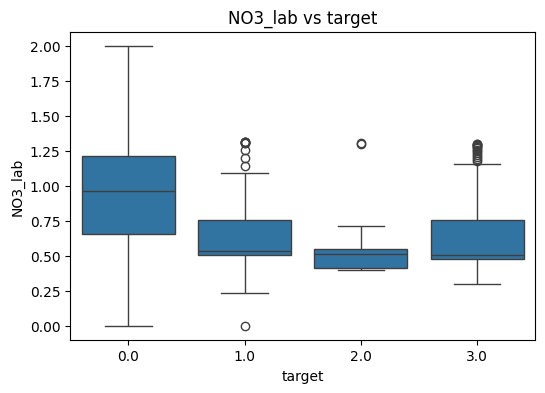

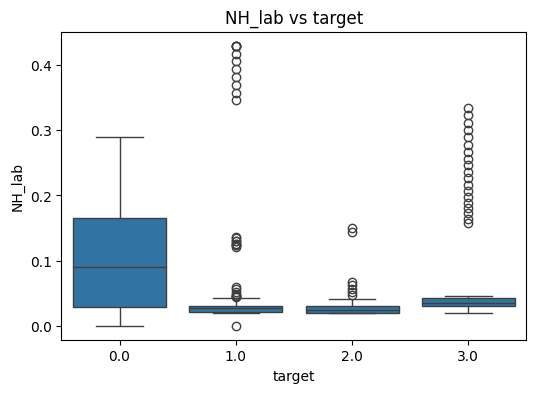

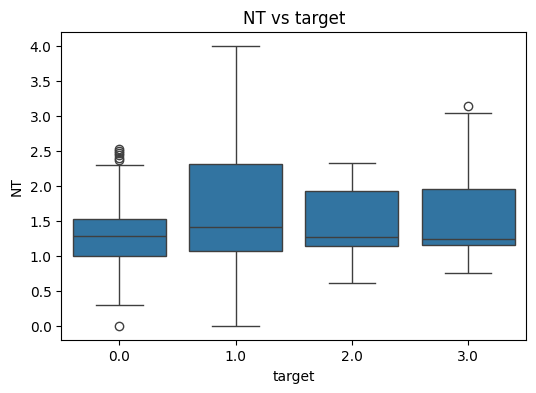

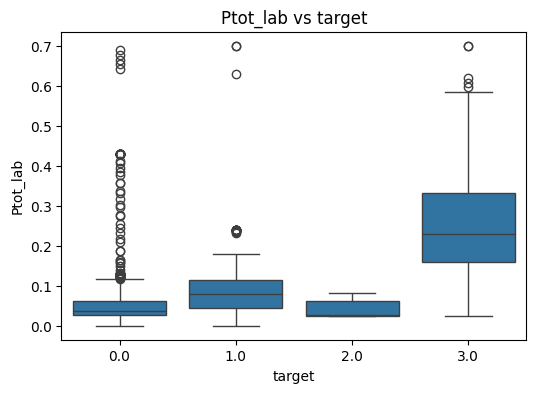

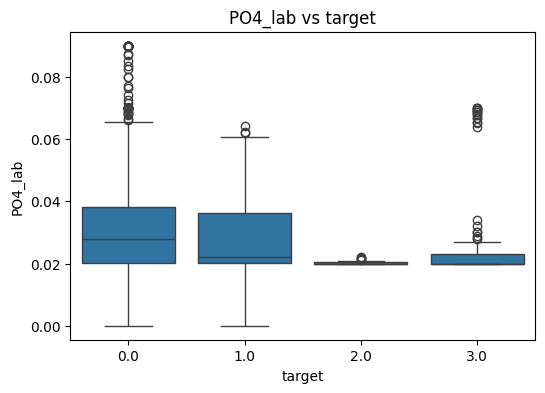

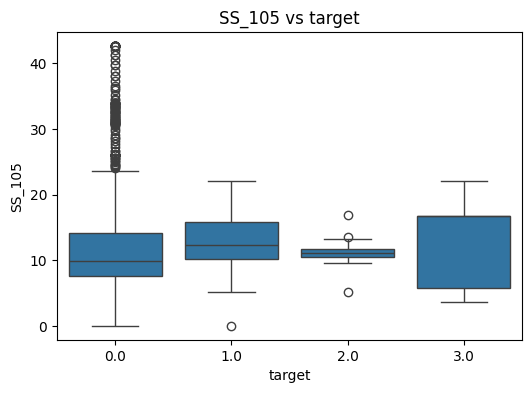

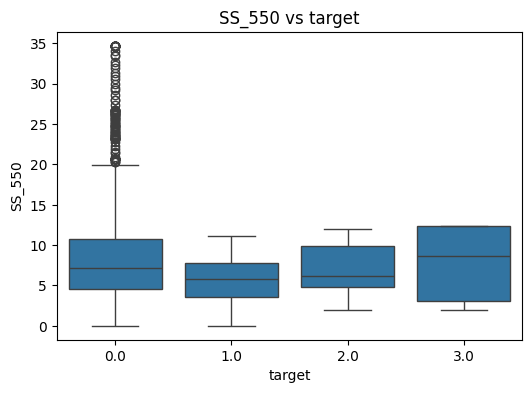

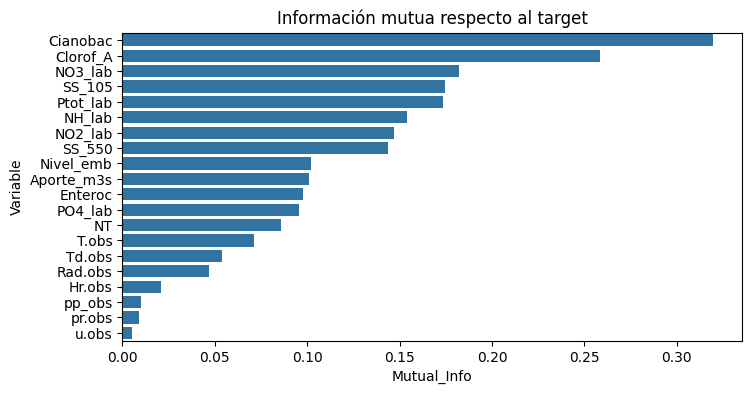

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Agrupación por tipo de variable (ajustá si usás más columnas)
meteorologicas = ['T.obs', 'Hr.obs', 'pr.obs', 'Rad.obs', 'u.obs', 'Td.obs', 'pp_obs']
hidrologicas = ['Aporte_m3s', 'Nivel_emb']
biologicas = ['Clorof_A', 'Enteroc', 'Cianobac']
quimicas = ['NO2_lab', 'NO3_lab', 'NH_lab', 'NT', 'Ptot_lab', 'PO4_lab', 'SS_105', 'SS_550']
otros = ['TempAmb', 'pHsupC', 'VientoI', 'SatSupC', 'T_sup', 'CondsupC']
target = 'target'

# 1. Resumen estadístico por grupo
def resumen_por_grupo(df, grupos):
    for nombre, columnas in grupos.items():
        print(f"\n### {nombre} ###")
        display(df[[col for col in columnas if col in df.columns]].describe().T)

# 2. Heatmap de correlaciones
def plot_correlaciones(df, cols, threshold=0.75):
    corr = df[cols].corr().abs()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", vmin=0.5, vmax=1)
    plt.title("Correlación entre variables")
    plt.show()

# 3. Boxplots por target
def boxplot_target(df, cols, target_col):
    for col in cols:
        if col in df.columns and df[col].nunique() > 5:
            plt.figure(figsize=(6, 4))
            sns.boxplot(x=target_col, y=col, data=df)
            plt.title(f'{col} vs {target_col}')
            plt.show()

# 4. Información mutua
def mutual_info(df, cols, target_col):
    X = df[cols].copy()
    y = df[target_col].copy()
    X = X.dropna()
    y = y.loc[X.index]
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = LabelEncoder().fit_transform(X[col])
    mi = mutual_info_classif(X, y, discrete_features='auto')
    mi_df = pd.DataFrame({'Variable': X.columns, 'Mutual_Info': mi}).sort_values(by='Mutual_Info', ascending=False)
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Mutual_Info', y='Variable', data=mi_df)
    plt.title("Información mutua respecto al target")
    plt.show()

# Llamadas sugeridas:
grupos = {
    "Meteorológicas": meteorologicas,
    "Hidrológicas": hidrologicas,
    "Biológicas": biologicas,
    "Químicas": quimicas,
    "Otros": otros
}

# Usá esto en tu notebook:
resumen_por_grupo(df, grupos)
plot_correlaciones(df, sum(grupos.values(), []))
boxplot_target(df, biologicas + quimicas, target)
mutual_info(df, biologicas + quimicas + hidrologicas + meteorologicas, target)



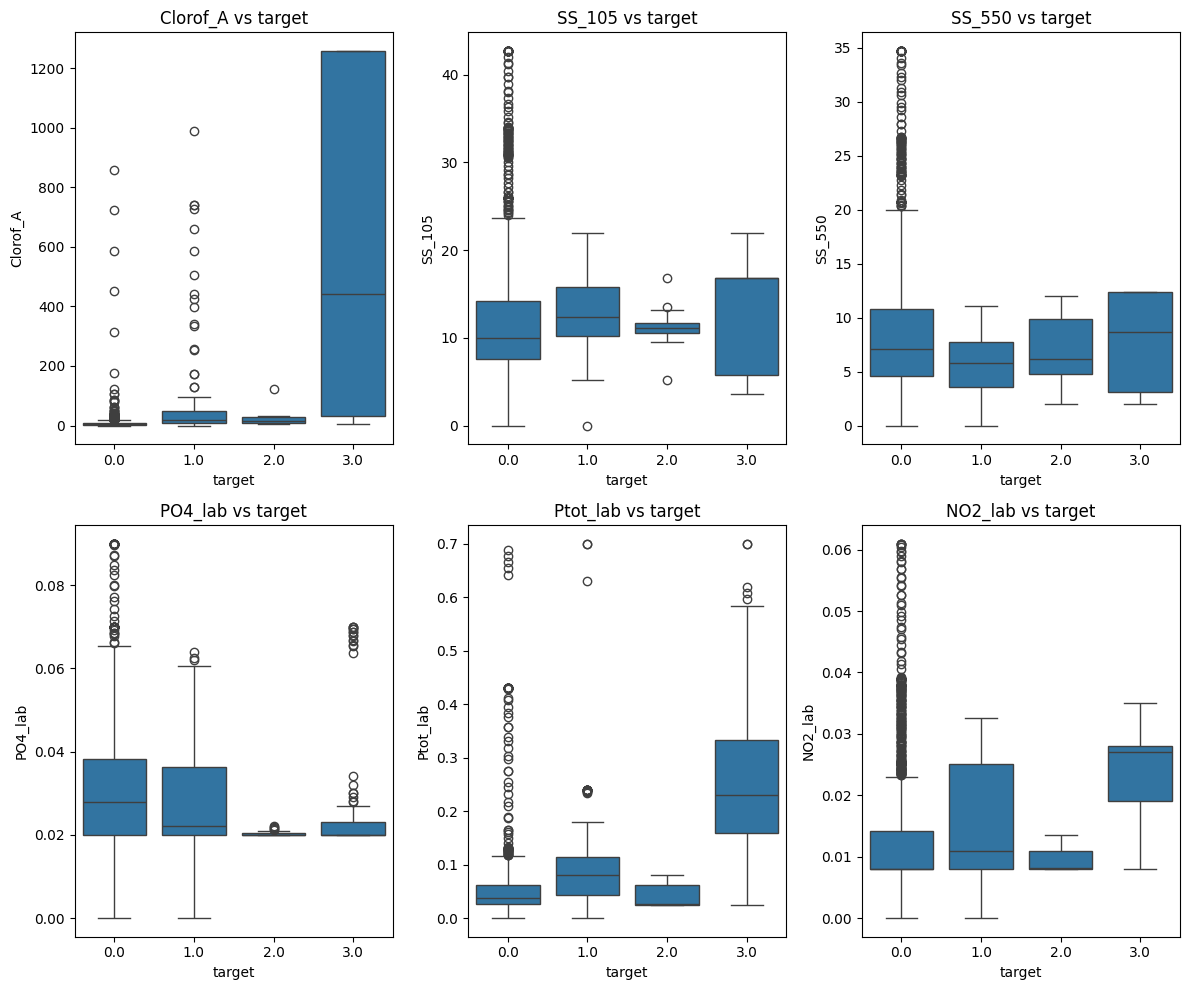

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
variables = ['Clorof_A', 'SS_105', 'SS_550', 'PO4_lab', 'Ptot_lab', 'NO2_lab']

for ax, var in zip(axs.ravel(), variables):
    sns.boxplot(x='target', y=var, data=df, ax=ax)
    ax.set_title(f'{var} vs target')

plt.tight_layout()
plt.savefig("Boxplots_Target_3x3.png", dpi=300)


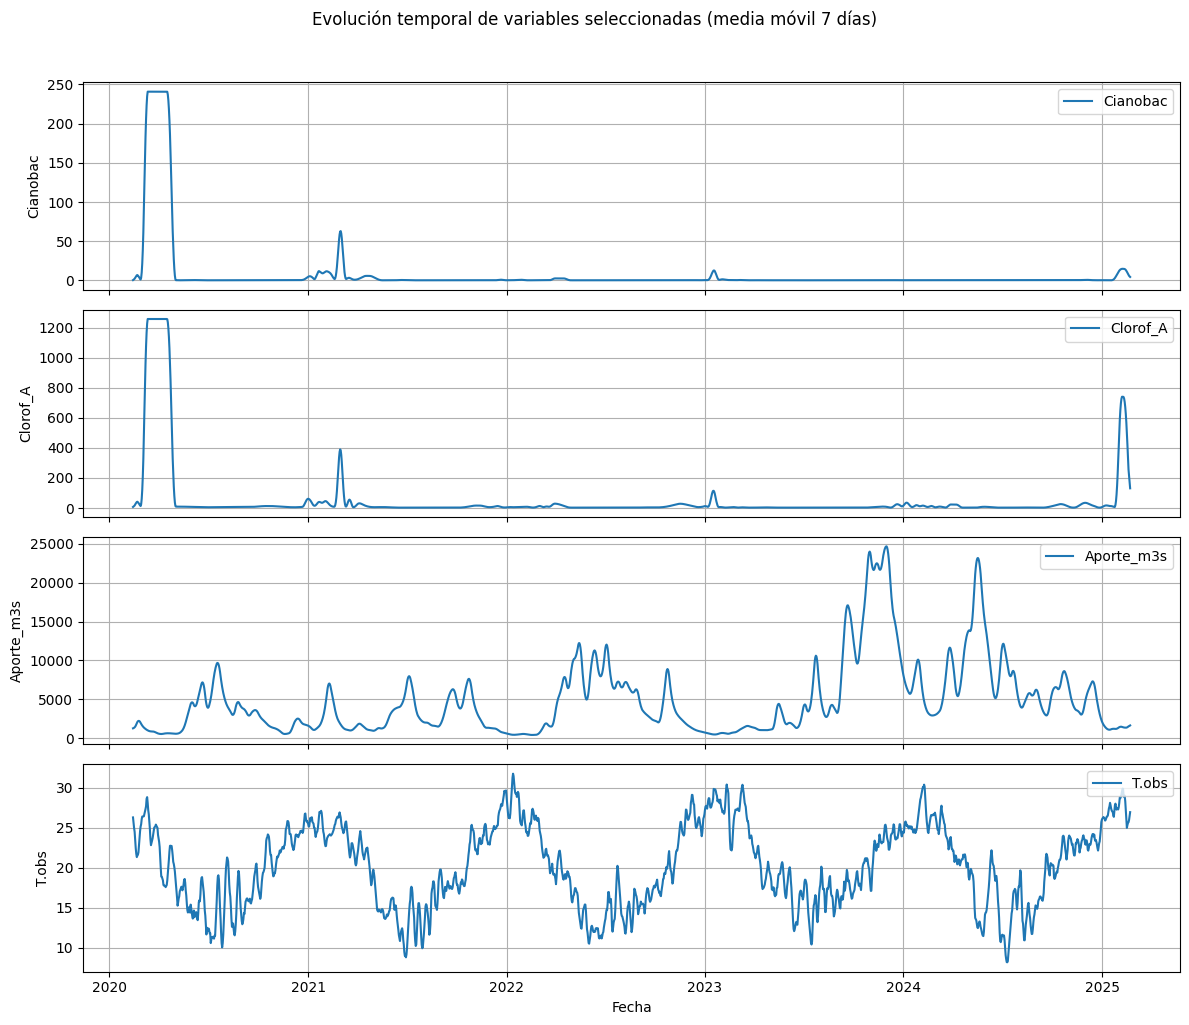

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Asegurar que 'time' esté en formato datetime y ordenado
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.sort_values('time')

# Variables a graficar
variables = ['Cianobac', 'Clorof_A', 'Aporte_m3s', 'T.obs']

# Calcular media móvil de 7 días
df_rolling = df.set_index('time')[variables].rolling(window=7, center=True, min_periods=1).mean()

# Graficar
fig, axes = plt.subplots(len(variables), 1, figsize=(12, 10), sharex=True)
for i, var in enumerate(variables):
    axes[i].plot(df_rolling.index, df_rolling[var], label=var)
    axes[i].set_ylabel(var)
    axes[i].legend(loc='upper right')
    axes[i].grid(True)

plt.xlabel('Fecha')
plt.suptitle('Evolución temporal de variables seleccionadas (media móvil 7 días)', y=1.02)
plt.tight_layout()
plt.savefig("Series_Temporales.png", dpi=300)
plt.show()
